In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import nltk

from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

# 10000개의 데이터로 예행연습


In [2]:
df = pd.read_excel("test_to_excel.xlsx")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 9877


In [3]:
# 위에서 5개를 뽑는다.
df[:5]

,appid,name,short_description,price,categories,genres,recommendations,release_date,developers,metacritic,image
0,1780820,Chill Corner - Piano & Guitar (Music Album),This DLC added 21 new soundtracks with the pri...,110000.0,"['싱글 플레이어', '다운로드 가능한 콘텐츠', 'Steam 도전 과제', 'St...","['캐주얼', '무료', '인디', '시뮬레이션']",NaN,2021년 12월 17일,['Low-Hi Tech'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...
1,1780830,Hundred Days - Napa Valley,Explore the napa valley region and its grape v...,950000.0,"['싱글 플레이어', '다운로드 가능한 콘텐츠', 'Steam 도전 과제', '컨트...","['인디', '시뮬레이션', '전략']",NaN,2021년 12월 21일,['Broken Arms Games'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...
2,1780840,Loch Ness,Loch Ness is a 1-4 Player Co-Op Horror Hunter....,1450000.0,"['싱글 플레이어', '멀티플레이어', '협동', '온라인 협동', 'Steam 도...","['인디', '앞서 해보기']",NaN,2021년 12월 3일,['JFi Games'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...
3,1780850,Cthulhu Dungeon,《不可名状的地牢》是一款以克苏鲁的呼唤跑团为背景的 战棋+DBG+Roguelike游戏，通...,750000.0,['싱글 플레이어'],"['인디', '전략', '앞서 해보기']",NaN,2022년 2월 18일,['SanYeGame'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...
4,1780880,Queue Simulator,Queue simulator brings you your favorite part ...,110000.0,"['싱글 플레이어', 'Steam 도전 과제']","['캐주얼', '인디', '대규모 멀티플레이어', 'RPG', '시뮬레이션']",NaN,2021년 12월 15일,['Just Making Games'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...


# stopword를 사용해서 불용어를 제거한다

In [4]:
df['short_description']
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\multicampus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 데이터 전처리 과정
cleaned 열에 기입한다.

In [5]:
# 아스키를 설정해서 불필요한 문자가 있는 것을 삭제한다.
def _removeNonAscii(s):
    return "".join(i for i in str(s) if  ord(i)<128)

# 문자를 모두 소문자로 바꾼다.
def make_lower_case(text):
    return text.lower()

# stopwords를 통해 불용어들을 제거한다.
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# 쓸데 없는 html 문자를 지운다.
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'',text)

# 
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['short_description'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

# 정제된 데이터를 확인

In [6]:

df['cleaned'][:5]


0    dlc added new soundtracks primary instrument p...
1    explore napa valley region grape varieties con...
2    loch ness player co op horror hunter team must...
3                                  dbg roguelikedbgmod
4    queue simulator brings favorite part mmorpg ex...
Name: cleaned, dtype: object

# 단어 단위로 벡터화를 위해 corpus에 담고, nan 값을 제거한다.
전체 문서의 수가 9877 에서 9395개로 바뀌었다.

In [7]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 9395


In [8]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

# 데이터 확인

In [9]:
corpus

[['dlc',
  'added',
  'new',
  'soundtracks',
  'primary',
  'instrument',
  'piano',
  'guitar'],
 ['explore',
  'napa',
  'valley',
  'region',
  'grape',
  'varieties',
  'continue',
  'journey',
  'winemaking',
  'world',
  'prove',
  'best'],
 ['loch',
  'ness',
  'player',
  'co',
  'op',
  'horror',
  'hunter',
  'team',
  'must',
  'navigate',
  'precarious',
  'waters',
  'use',
  'equipment',
  'hunt',
  'nessies',
  'feeding',
  'ground',
  'lay',
  'bait',
  'lure',
  'out',
  'careful',
  'lurking',
  'deep',
  'beneath',
  'lake',
  'creature',
  'ancient',
  'mankind'],
 ['dbg', 'roguelikedbgmod'],
 ['queue',
  'simulator',
  'brings',
  'favorite',
  'part',
  'mmorpg',
  'experience',
  'waiting',
  'queue'],
 ['model',
  'trainz',
  'nsw',
  'rails',
  'n',
  'scale',
  'model',
  'train',
  'layout',
  'set',
  'late',
  's',
  'early',
  's',
  'new',
  'south',
  'wales',
  'nsw',
  'region',
  'australia',
  'grab',
  'favourite',
  'nsw',
  'or',
  'vr',
  'v',
 

# 가장 중요한 word2vec 작업
1. word2vec을 위한 신경망을 만든다.
2. courpus를 학습시킨다.
3. 신뢰성을 높이기 위해 Kaggle에서 가져와서 데이터를 가져와서 학습시킨다.

데이터가 충분하지 않은 상황이기 때문에 pre-trained된 데이터를 가져와서 로드하고 초기 단어 벡터값으로 사용한다.

### 먼저 버전을 맞춘다. 4.0 버전이기 때문에 3.8로 맞춰줘야한다.


In [15]:
pip install --upgrade gensim==3.8.3
# 오류나면 --user 넣는다.

Note: you may need to restart the kernel to use updated packages.


In [16]:
#### % time
# word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

# 정제한 데이터들을 벡터화 시킨다.
각 문서에 대해서 벡터 리스트로 바꾼다.

In [17]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [18]:
document_embedding_list = get_document_vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

C:\Users\multicampus\AppData\Local\Temp\ipykernel_21476\913432021.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
C:\Users\multicampus\AppData\Local\Temp\ipykernel_21476\913432021.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


문서 벡터의 수 : 9350


# 4. 추천 시스템 구현하기

각 문서 벡터 간의 코사인 유사도를 구합니다.




In [19]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (9350, 9350)


선택한 영화 이름에 대해서 코사인 유사도를 이용하여 가장 줄거리가 유사한 5개의 영화를 찾아내는 함수를 만듭니다.

In [20]:
def recommendations(name):
    movies = df[['name', 'image']]

    # 영화 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['name']).drop_duplicates()    
    idx = indices[name]

    # 입력된 영화과 줄거리(document embedding)가 유사한 영화 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 영화 5권의 인덱스
    movie_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = movies.iloc[movie_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        try:
            response = requests.get(row['image'])
            img = Image.open(BytesIO(response.content))
            fig.add_subplot(1, 5, index + 1)
            plt.imshow(img)
            plt.title(row['name'])
        except:
            continue

영화 제목을 입력으로 넣으면 해당 영화의 문서 벡터(줄거리 벡터)와 유사한 문서 벡터값을 가진 영화를 추천해줍니다. 
영화 제목과 이미지를 출력합니다.

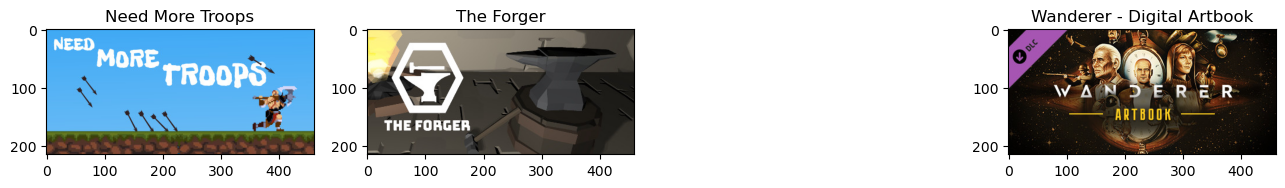

In [21]:
recommendations("Loch Ness")
